# ASTR 540 Homework 2 - Ansh Gupta

In [629]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as c
from scipy.optimize import curve_fit
import scipy.stats as st

# Problem 2
## a)

In [568]:
# read in the radial velocity datafile, assigning column names
names = ['r_proj', 'v_r', 'v_r_err']
df = pd.read_csv('rv.dat', delimiter=' ', names=names)

# set distance and convert the project radii in arcsec to kpc
d = 20*u.Mpc
r_proj_as = df['r_proj'].values * u.arcsec
r_proj = r_proj_as.to(u.rad)*d.to(u.kpc)/u.rad

# read radial velocity measurements and errors
v_r = df['v_r'].values * u.km/u.s
v_r_err = df['v_r_err'].values * u.km/u.s

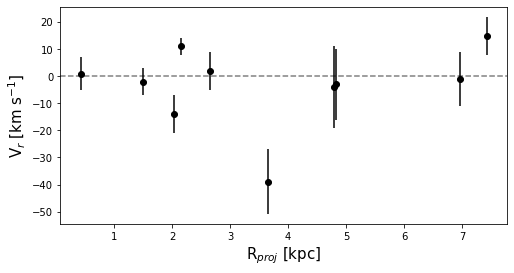

In [569]:
# make a plot of radial velocity vs projected radius (just to visualize)
plt.figure(figsize=(8, 4))
plt.errorbar(r_proj, v_r, yerr=v_r_err, fmt='o', c='k')
plt.axhline(0, c='grey', ls='--', zorder=-1)
plt.xlabel("R$_{proj}$ [kpc]", fontsize=15)
plt.ylabel(r'V$_r$ [km s$^{-1}$]', fontsize=15);

My general strategy to do the mass estimate is to make a plot of the cumulative counts as a function of radius, as in Fig 3 from the Evans paper. I did some calculations on the top of my written work to show how different values of gamma translate to this plot. From there, I can do a curvefit to determine the best-fit gamma to use for the calculation of the constant C, and then apply the "tracer mass estimator".

In [630]:
def cumulative_N(r, nbins=10):
    '''Compute N(<R) and its error
    
    INPUTS
    ------
    r: `numpy array`
        Projected radius values in sample (in kpc)
    nbins: `int`
        Number of bins of width 1kpc to count the number of galaxies within
        
    OUTPUTS
    -------
    N: `numpy array`
        Cumulative number of galaxy counts contained within the upper edge of each bin
    N_err: `numpy array`
        Error on N assuming Poisson statistics
    upper_r: `numpy array`
        Upper bin edges, at which N(<R) is calculated (in kpc)
    '''
    
    # make a histogram to count up the number of galaxies in 1kpc bins
    bins = np.arange(nbins)
    bins = np.arange(10)
    hist = plt.hist(r.value, bins=bins)
    plt.close()

    # get the upper bin edges since it's N(<R)
    upper_r = hist[1][1:]

    # get cumulative counts on the number of galaxies contained at each radius
    N = np.cumsum(hist[0])
    N_err = np.sqrt(N) # assuming Poisson stats
    
    return N, N_err, upper_r

In [571]:
# compute N(<R) and its error for our sample
N, N_err, upper_r = cumulative_N(r_proj)

In [574]:
# see the top of my paper work to see how I derive this
def plaw(r, C, gamma):
    return C * r**(3 - gamma)

In [575]:
# fit the derived power law function to the data to get a best-fit gamma
popt, _ = curve_fit(plaw, upper_r, N, sigma=N_err)
gamma = popt[1]

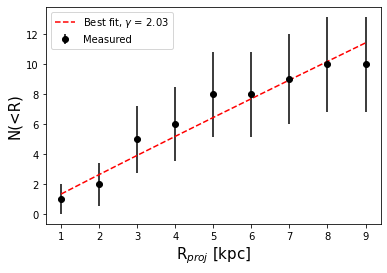

In [577]:
# plot the measured cumulative counts and the best-fit function
plt.errorbar(r_proj_binned, N, yerr=N_err, fmt='o', c='k', label='Measured')
plt.plot(r_proj_binned, plaw(upper_r, *popt), c='red', ls='--', \
         label=r'Best fit, $\gamma$ = ' + f'{gamma:.3}')

plt.xlabel("R$_{proj}$ [kpc]", fontsize=15)
plt.ylabel(r'N(<R)', fontsize=15)
plt.legend();

In [578]:
# C constant as defined in Evans+2003
def C_evans(gamma, alpha=0):
    # Since we're looking in from the very center of the galaxy, presumably, set r_in = 0, which
    # sets the third piece of the expression for C to unity in the expression from the paper.
    term1 = 4 * (alpha + gamma)/np.pi
    term2 = (4 - alpha - gamma)/(3 - gamma)
    return term1 * term2

In [580]:
# Compute the best-fit mass using the "tracer mass estimator"
M = (C_evans(gamma)/c.G/len(v_r) * np.sum(v_r**2 * r_proj)).to(u.Msun)
print(f"Galaxy tracer mass estimate: {M:.2e}")

Galaxy tracer mass estimate: 9.79e+08 solMass


## b)

In [587]:
def bootstrap_resample(r, v, v_err, n_samples):
    """Perform bootstrapping resampling on r and v data.

    INPUTS
    ------
    r: `numpy array`
        Projected radius values in sample (in kpc)
    v: `numpy array`
        Radial velocity measurements in sample (in km/s)
    v_err: `numpy array`
        Radial velocity errors in sample (in km/s)
    n_samples: `int`
        Number of samples to generate via bootstrapping

    RETURNS
    -------
    bootstrap_r: `list`
        List containing numpy arrays of bootstrapped r data (in kpc)
    bootstrap_v: `list`
        List containing numpy arrays of bootstrapped v data (in km/s)
    bootstrap_v_err: `list`
        List containing numpy arrays of bootstrapped v_err data (in km/s)
    """
    
    bootstrap_r = []
    bootstrap_v = []
    bootstrap_v_err = []
    n_r = len(r)

    for _ in range(n_samples):
        # generate random samples of r 
        indices = np.random.choice(n_r, n_r, replace=True)
        resampled_r = r[indices]
        bootstrap_r.append(resampled_r)
        
        # add the v and v_err values associated with the resampled radii
        resampled_v = v[indices]
        bootstrap_v.append(resampled_v)
        resampled_v_err = v_err[indices]
        bootstrap_v_err.append(resampled_v_err)

    return bootstrap_r, bootstrap_v, bootstrap_v_err

In [605]:
num_samples = 1000
bootstrap_r, bootstrap_v, bootstrap_v_err = bootstrap_resample(r_proj, v_r, v_r_err, num_samples)
bootstrap_M = np.zeros(num_samples)

In [634]:
# repeat the procedure in part a) for each of the bootstrapped samples
for i in range(num_samples):
    
    # get the bootstrapped data for each sample
    r_i = bootstrap_r[i]
    v_i = bootstrap_v[i]
    v_err_i = bootstrap_v_err[i]
    
    # compute N(<R) and its error
    N_i, N_err_i, upper_r_i = cumulative_N(r_i)
    
    mask_zeros = np.where(~(N_i == 0))

    # fit the derived power law function to get a best-fit gamma
    try:
        popt_i, _ = curve_fit(plaw, upper_r_i[mask_zeros], N_i[mask_zeros], sigma=N_err_i[mask_zeros])
    except:
        print('crap')
        continue
        
    gamma_i = popt_i[1]
    
    M_i = (C_evans(gamma_i)/c.G/len(v_i) * np.sum(v_i**2 * r_i)).to(u.Msun)
    bootstrap_M[i] = M_i.value

In [652]:
print(f"Bootstrap tracer mass estimate: {np.mean(bootstrap_M):.2e} M_sun")
print(f"Bootstrap tracer mass standard deviation: {np.std(bootstrap_M):.2e} M_sun")

# We have evidence of dark matter roughly if the mass is > stellar mass, so
# compute the number of standard deviations away the stellar mass of 2*10^8
# Msun is awat from our bootstrap mean
n_std_away = (np.mean(bootstrap_M) - 2e8)/ np.std(bootstrap_M)  

# Our sample definitely isn't Gaussian, but as an estimate let's just run
# with it to compute a rough probability of our mass bring less than
# or equal to the stellar mass, aka no dark matter.
print(f"Probability of no dark matter: {1 - st.norm.cdf(n_std_away):.3}")

Bootstrap tracer mass estimate: 1.05e+09 M_sun
Bootstrap tracer mass standard deviation: 7.25e+08 M_sun
Probability of no dark matter: 0.121


## c)

Let's do an MCMC using Bayesian inference!

The total likelihood is the product of all of the probabilities
for each velocity to be sampled from a gaussian. However, I
need to take into account the known uncertainties on the measurements.
I'm not sure how best to do this, but one idea is to consider the
overall probability as the probability of a point being sampled from a
gaussian with a trial width, sigma, convolved with the probability of a
point having its value of v. If we assume that the uncertainty on the
measured radial velocity for each tracer is itself normally distributed,
then the convolution of these two products is just a convolution of the
two gaussian ditributions. For the overall population gaussian we are
proposing, we know the mean (0, since the orbits are isotropic) and
SD (sigma, our test standard deviation), and we know the SD of the
gaussian for each point (v_r_err), but we don't know the mean of each
point's gaussian. I went down several rabbit holes trying to figure out
how to incorporate their mean, but couldn't find a good way to. It's a
bad assumption, but I'm just going to throw away the informaion about
their mean for now. In a very rough sense, this is justified by
assuming that their mean is exactly their measured value, which would
make the exponenent of the normal PDF = 0, leaving only the SD term
in the front as a contribution. The effect of this is to "widen" the
overall probability distribution like we expect from a convolution. From
the central limit theorem, we know that the standard deviation of the convolution
of two Gaussians add in quadrature. So that's what I go with below.

In [836]:
# We assume the velocities are normally distributed
def likelihood(v, v_err, sigma):
    # gaussian centered at v=0 (isotropic), uncertainties added in quadrature (see above)
    gaussian = st.norm(0, np.sqrt(sigma**2 + v_err.value**2)) 
    return np.prod(gaussian.pdf(v))
    
# I have no reason to use a particular informed prior so just use a uniform
def prior(sigma):
    return 1

def new_sample(sigma, scale=0.5):
    return sigma + np.random.normal(scale=scale)

In [837]:
# Here I implement a basic Metropolis-Hastings MCMC algorithm
def metropolis_hastings(v, v_err, n_iterations):
    sigma = 1 # initial value for the intrinsic galaxy velocity dispersion
    samples = [sigma]

    for _ in range(n_iterations):
        # trial value for new sigma
        sigma_new = new_sample(sigma)
        
        # we have an uninformed prior, so the acceptance ratio is just ratio of the likelihoods
        acceptance_ratio = min(1, likelihood(v, v_err, sigma_new) / likelihood(v, v_err, sigma))
        
        # randomly admit the new sigmas based on the acceptance ratio, a d sigma must be >0
        if np.random.uniform() < acceptance_ratio and sigma_new > 0:
            sigma = sigma_new

        samples.append(sigma)

    return samples

In [838]:
# Run the MCMC to generate samples for sigma
n_iterations = 100000
samples = metropolis_hastings(v_r, v_r_err, n_iterations)

Text(0, 0.5, '$\\sigma$ [km s$^{-1}$]')

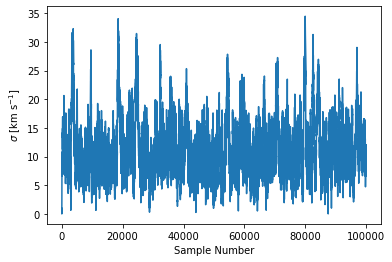

In [839]:
plt.plot(samples)
plt.xlabel('Sample Number')
plt.ylabel(r'$\sigma$ [km s$^{-1}$]')

Looks like we converged fairly decently. I'm going to cut out the first ~1000 samples to clear out the burn in period (it probably reached the final average value a lot faster than that but we have enough samples to safely throw that many away). Then I'll take the average of everything left to get a final derived value for the radial component of the velocity dispersion. And since the orbits are isotropic, the final velocity dispersion is just 3 times this.

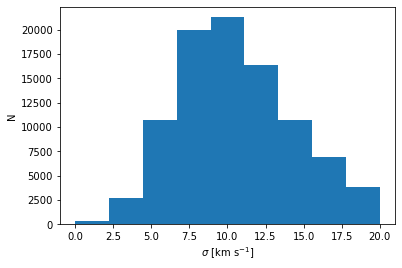

In [853]:
# Our final sample distribution isn't super duper Gaussian, so either I don't have
# enough samples, my likelihood function isn't perfect, or something else. The
# odd spikes in my sampling procedure make me think it could be a mistake in my
# likelihood function, but I also manually force the sigma values to be greater
# than 0 which might push the distribution slightly up.
plt.hist(samples[1000:], bins=np.linspace(0, 20, 10))
plt.xlabel(r'$\sigma$ [km s$^{-1}$]')
plt.ylabel('N');

In [870]:
sigma_r = np.mean(samples[1000:])
sigma_r_unc = np.std(samples[1000:])
print(f'Radial velocity dispersion: {sigma_r:.4} ± {sigma_r_unc:.2} km/s ')
print(f'3D velocity dispersion: {3*sigma_r:.4} ± {3*sigma_r_unc:.3} km/s')

Radial velocity dispersion: 11.4 ± 4.9 km/s 
3D velocity dispersion: 34.19 ± 14.7 km/s


# Problem 5

In [294]:
def plumber_v(r, a=1, G=1, M=1):
    num = np.sqrt(G*M)*r
    den = (r**2 + a**2) ** (3/4)
    return num/den

Here's a computer-generated plot of the Plumber sphere model to be sure of the peak V and the associated R value as I derived on paper. From the plot, we can see that the velocity peaks at $r = \sqrt{2}a_P$ as expected.

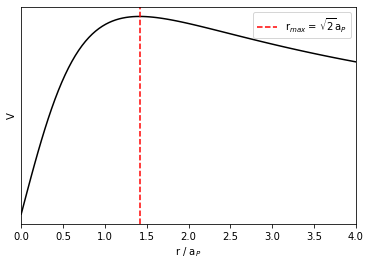

In [293]:
rs = np.linspace(0, 4, 100)
v = plumber_v(rs)

plt.figure(figsize=(6, 4))
plt.plot(rs, v, c='k')
plt.axvline(np.sqrt(2), label=r'r$_{max}$ = $\sqrt{2}$a$_{P}$', c='r', ls='--')

plt.xlim(0, 4)
plt.xlabel(r'r / a$_{P}$')
plt.ylabel(r'V')
plt.gca().set_yticklabels([])
plt.gca().set_yticks([])
plt.legend();

Next, the spider diagram. I neglect the factor of sin(i) since it gets multiplied into the measured velocity values but then immediately divided out since it's multiplied into the units of the contours we're asked to label. Interestingly, I notice that the 0.8 contour forms a closed loop instead of going off. This would imply that the maximum value for the velocity is not at the edge of the disk, but somewhere inside that 0.8 contour bubble. I show the negative velocities as dashed lines, as in Sparke and Gallagher Fig 5.19.

In [279]:
phis = np.linspace(0, 360, 360) * np.pi/180
X, Y = np.meshgrid(rs, phis)
rv, _ = np.meshgrid(v/np.max(v), phis)
rv2, _ = np.meshgrid(-1*v/np.max(v), phis)

Z1 = (np.cos(phis) * rv.T).T
Z2 = (np.cos(phis) * rv2.T).T

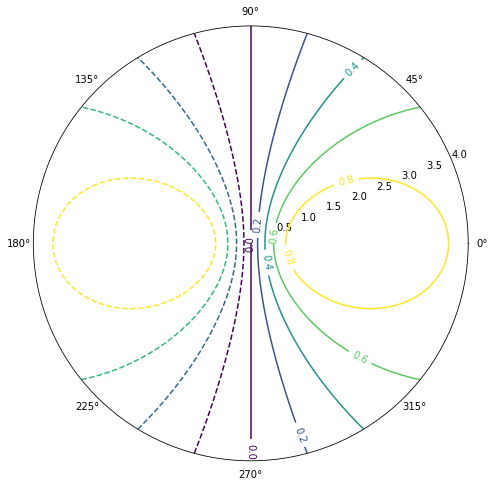

In [296]:
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(8, 8))

CS = ax.contour(Y, X, Z1, levels=[0, 0.2, 0.4, 0.6, 0.8])
CS2 = ax.contour(Y, X, Z2, levels=[0.2, 0.4, 0.6, 0.8], linestyles='--')

ax.clabel(CS, CS.levels, inline=1)

# ax.clabel(CS2, CS2.levels)
# ax.set_xticklabels([])
# ax.set_yticklabels([])
ax.grid(False)

Sorry for the  sloppy plot - I couldn't figure out how to label the radius values in a nice way. And I can't figure out why the contours have two labels each.